**2019 Indonesian Presidential Election Tweet Sentiment Analysis**



In [ ]:
!pip install nlp-id
!pip install scikeras
!pip install optuna
!pip install keras-tuner

In [140]:
from google.colab import drive
drive.mount('/content/drive')

import re
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)

pd.set_option('display.max_colwidth', None)

data_path = "/content/drive/MyDrive/Colab Notebooks/indonesiaAI/assignment/project_1_sentiment analysis/to submit/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1 Load Data

In [141]:
# load
df = pd.read_csv(data_path + "tweet.csv", index_col=None, encoding='utf-8')
print(df.shape)
df.head()

(1815, 3)


,Unnamed: 0,sentimen,tweet
0,0,negatif,"Kata @prabowo Indonesia tidak dihargai bangsa asing! Berita ini ðŸ‘‡ pasti hoax buatan penguasa, ya kan @rockygerung?ðŸ˜œ https://twitter.com/mediaindonesia/status/1117575436337160192?s=21Â â€¦"
1,1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib Luthfi Seharga Mercy? http://dlvr.it/R2pvZVÂ"
2,2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik. #01IndonesiaMaju #JokowiLagi #JokowiMenangTotalDebat pic.twitter.com/W2ythnxsTp"
3,3,positif,"Bagi Sumatera Selatan, Asian Games berdampak pd ekonomi langsung diprediksi mencapai 18,5 triliun. Indonesia maju, Jokowi hebat!"
4,4,negatif,"Negara kita ngutang buat bngun infrastruktur yang udah dipake masyarakat, terus masyarakatnya ngeluh karena negara ngutang, setiap negara itu pasti ngutang, utang bisa dibayar kalo negara dapet penghasilan. Penghasilan negara itu ya dari pajak"


In [ ]:
df = df[['sentimen', 'tweet']]

# 2 Exploratory Data Analysis

## 2.1 Label Counts and Proportion

In [ ]:
# class counts
df.sentimen.value_counts()

positif    612
netral     607
negatif    596
Name: sentimen, dtype: int64

In [ ]:
# class proportion
df.sentimen.value_counts(normalize=True)

positif    0.337190
netral     0.334435
negatif    0.328375
Name: sentimen, dtype: float64

Class proportion is balance

## 2.2 Keywords and Hashtags Exploration

In [ ]:
# president names exploration
tweet = df[['sentimen', 'tweet']].groupby(['sentimen']).count().sort_values(
    'tweet', ascending=False)

jkw_only = df[['sentimen', 'tweet']].query(
    'tweet.str.contains("jokowi", case = False) & ~tweet.str.contains(\
    "prabowo", case = False)')\
        .groupby('sentimen').count()\
                .rename(columns={'tweet': 'jokowi & ~prabowo'})

pbw_only = df[['sentimen', 'tweet']].query(
    'tweet.str.contains("prabowo", case = False) & ~tweet.str.contains(\
        "jokowi", case = False)')\
        .groupby('sentimen').count()\
                .rename(columns={'tweet': 'prabowo & ~jokowi'})

pbw_jkw = df[['sentimen', 'tweet']].query(
    'tweet.str.contains("prabowo", case = False) & \
        tweet.str.contains("jokowi", case = False)')\
        .groupby('sentimen').count()\
                .rename(columns={'tweet': 'prabowo & jokowi'})

not_pbw_jkt = df[['sentimen', 'tweet']].query(
    '~tweet.str.contains("prabowo", case = False) & \
        ~tweet.str.contains("jokowi", case = False)')\
                .groupby('sentimen').count()\
                        .rename(columns={'tweet': '~prabowo & ~jokowi'})

pbw_jkt_count = pd.concat([tweet,
                           jkw_only,
                           pbw_only,
                           pbw_jkw,
                           not_pbw_jkt],
                          axis=1)

pbw_jkt_total = pd.DataFrame({'total': [pbw_jkt_count['tweet'].sum(),
                                        pbw_jkt_count['jokowi & ~prabowo'].sum(),
                                        pbw_jkt_count['prabowo & ~jokowi'].sum(),
                                        pbw_jkt_count['prabowo & jokowi'].sum(),
                                        pbw_jkt_count['~prabowo & ~jokowi'].sum()]},
                             index=['tweet',
                                    'jokowi & ~prabowo',
                                    'prabowo & ~jokowi',
                                    'prabowo & jokowi',
                                    '~prabowo & ~jokowi']).T

pbw_jkt_combine = pd.concat([pbw_jkt_count, pbw_jkt_total], axis = 0)

pbw_jkt_combine

,tweet,jokowi & ~prabowo,prabowo & ~jokowi,prabowo & jokowi,~prabowo & ~jokowi
positif,612,219,250,54,89
netral,607,205,211,98,93
negatif,596,162,168,71,195
total,1815,586,629,223,377


**Findings**  
The word 'Prabowo' and 'Jokowi' for each sentiment is balance

Next, check the hashtag:

In [ ]:
df['hashtags'] = df['tweet'].str.extractall(r'(#\w+)').unstack().apply(
    lambda x: ' '.join(x.dropna()), axis=1)
df.head(10)

,sentimen,tweet,hashtags
0,negatif,Kata @prabowo Indonesia tidak dihargai bangsa ...,NaN
1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib...",NaN
2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik....",#01IndonesiaMaju #JokowiLagi #JokowiMenangTota...
3,positif,"Bagi Sumatera Selatan, Asian Games berdampak p...",NaN
4,negatif,Negara kita ngutang buat bngun infrastruktur y...,NaN
5,netral,"Yg bisikin pak jokowi, cm mikirin perputaran d...",NaN
6,positif,Masa tenang msih ngoceh aja..ttp jokowi harga ...,NaN
7,positif,#UASdifitnahKejiBalasDiTPS kerjasa ekonomi b...,#UASdifitnahKejiBalasDiTPS #UASdifitnahKejiBal...
8,netral,"Iya bener Aa, kita MANTAP kan pilihan ke Pemim...",NaN
9,negatif,Prabowo-Sandi Sepakat Tak Ambil Gaji karena Ne...,#GoAceh


In [ ]:
# hashtag exploration
pd.options.display.max_rows = None

pos = pd.DataFrame(
    df[['sentimen', 'hashtags']].query(
        'sentimen == "positif"')['hashtags'].str.findall(
            r'#\w+').explode().value_counts())

net = pd.DataFrame(
    df[['sentimen', 'hashtags']].query(
        'sentimen == "netral"')['hashtags'].str.findall(
            r'#\w+').explode().value_counts())

neg = pd.DataFrame(
    df[['sentimen', 'hashtags']].query(
        'sentimen == "negatif"')['hashtags'].str.findall(
            r'#\w+').explode().value_counts())

hash = pd.DataFrame(
    df['hashtags'].str.findall(r'#\w+').explode().value_counts())

pd.concat([pos, net, neg, hash],
          axis = 1,
          keys = ['positif',
                  'netral',
                  'negatif',
                  'total']).fillna(0).astype(int).sort_values(
                      ('total', 'hashtags'), ascending=False
                  ).head(20)

,positif,netral,negatif,total
,hashtags,hashtags,hashtags,hashtags
#PrabowoSalahkanSBY,20,35,35,90
#PilihOrangBaik,32,29,0,61
#PilihBajuPutih,29,31,0,60
#PilihJelasIslamnya,27,28,0,55
#JokowiMenangTotalDebat,24,23,8,55
#UASdifitnahKejiDanBrutal,16,4,14,34
#DebatPilpres2019,6,11,5,22
#TusukPrabowoSandi,10,5,6,21
#2019GantiPresiden,4,15,1,20


**Findings**  
The dataset is somewhat balanced, but the hashtags are inconclusive about which sentiment it belongs to.

I will split the data into 12 parts, visualize it in wordcloud to give some ideas about its' topic, and transform them into vectors for further analysis.

## 2.3 WordCloud  
WordCloud helps visualizing the keywords for each sentiment

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans

In [ ]:
# jokowi
jokpos = df.query('sentimen == "positif" & tweet.str.contains("jokowi", case = False) \
                  & ~tweet.str.contains("prabowo", case = False)').drop(columns = ['sentimen', 'hashtags'])
joknet = df.query('sentimen == "netral" & tweet.str.contains("jokowi", case = False) \
                  & ~tweet.str.contains("prabowo", case = False)').drop(columns = ['sentimen', 'hashtags'])
jokneg = df.query('sentimen == "negatif" & tweet.str.contains("jokowi", case = False) \
                  & ~tweet.str.contains("prabowo", case = False)').drop(columns = ['sentimen', 'hashtags'])

jokposlist = [i for i in jokpos['tweet']]
joknetlist = [i for i in joknet['tweet']]
jokneglist = [i for i in jokneg['tweet']]

# prabowo
prapos = df.query('sentimen == "positif" & tweet.str.contains("prabowo", case = False) \
                  & ~tweet.str.contains("jokowi", case = False)').drop(columns = ['sentimen', 'hashtags'])
pranet = df.query('sentimen == "netral" & tweet.str.contains("prabowo", case = False) \
                  & ~tweet.str.contains("jokowi", case = False)').drop(columns = ['sentimen', 'hashtags'])
praneg = df.query('sentimen == "negatif" & tweet.str.contains("prabowo", case = False) \
                  & ~tweet.str.contains("jokowi", case = False)').drop(columns = ['sentimen', 'hashtags'])

praposlist = [i for i in prapos['tweet']]
pranetlist = [i for i in pranet['tweet']]
praneglist = [i for i in praneg['tweet']]

# both
duopos = df.query('sentimen == "positif" & tweet.str.contains("jokowi", case = False) \
                  & tweet.str.contains("prabowo", case = False)').drop(columns = ['sentimen', 'hashtags'])
duonet = df.query('sentimen == "netral" & tweet.str.contains("jokowi", case = False) \
                  & tweet.str.contains("prabowo", case = False)').drop(columns = ['sentimen', 'hashtags'])
duoneg = df.query('sentimen == "negatif" & tweet.str.contains("jokowi", case = False) \
                  & tweet.str.contains("prabowo", case = False)').drop(columns = ['sentimen', 'hashtags'])

duoposlist = [i for i in duopos['tweet']]
duonetlist = [i for i in duonet['tweet']]
duoneglist = [i for i in duoneg['tweet']]

# None
nopos = df.query('sentimen == "positif" & ~tweet.str.contains("jokowi", case = False) \
                 & ~tweet.str.contains("prabowo", case = False)').drop(columns = ['sentimen', 'hashtags'])
nonet = df.query('sentimen == "netral" & ~tweet.str.contains("jokowi", case = False) \
                 & ~tweet.str.contains("prabowo", case = False)').drop(columns = ['sentimen', 'hashtags'])
noneg = df.query('sentimen == "negatif" & ~tweet.str.contains("jokowi", case = False) \
                 & ~tweet.str.contains("prabowo", case = False)').drop(columns = ['sentimen', 'hashtags'])

noposlist = [i for i in nopos['tweet']]
nonetlist = [i for i in nonet['tweet']]
noneglist = [i for i in noneg['tweet']]

df = df.drop(columns = ['hashtags'])

In [ ]:
def plot_wordcloud(text, title=None, max_words=200, width=800, height=400):
    wordcloud = WordCloud(max_words=max_words,
                          width=width,
                          height=height,
                          background_color='white').generate(text)
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# get the top 10 words for each cluster
def get_top_words(X, n_words, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)
    common_words = kmeans.cluster_centers_.argsort()[:,-1:-n_words-1:-1]
    word_list = vectorizer.get_feature_names_out()
    for num, centroid in enumerate(common_words):
        print(str(num) + ' : ' + ', '.join(word_list[word] for word in centroid))

In [ ]:
# use TF-IDF
vectorizer = TfidfVectorizer(max_features=1000,
                             ngram_range=(1, 3),
                             max_df=0.5, min_df=2,
                             norm='l2',
                             sublinear_tf=True,
                             use_idf=True,
                             smooth_idf=True,
                             lowercase=True,
                             strip_accents='unicode',
                             token_pattern=r'(?u)\b\w\w+\b')
svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(vectorizer, svd, normalizer)



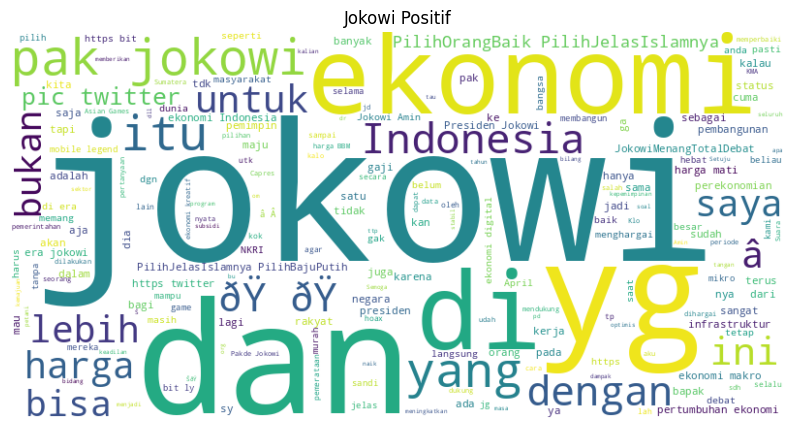

In [ ]:
# jokowi positif
plot_wordcloud(' '.join(jokposlist), title = 'Jokowi Positif')

In [ ]:
# top 10 words for Jokowi Positif
X = lsa.fit_transform(jokposlist)
get_top_words(X,10,3) #10 n_words and 3 n_clusters

0 : 01, 01 yuk, 18 keberhasilan, 01indonesiamaju, 18, 17aprilcoblosjokowiamin, 24 22563621, 2018 09, 38106 warga puncak, atlet
1 : 01, 01 yaa, 02, 01 yaa https, 09 24, 2019, TMruf, 09, balik, 17
2 : 01 yaa https, 01, 09, 01 yuk, 09 24, 2019jokowikyaimaruf, 22563621, 38106, 2019tetapjokowi, 09 24 22563621


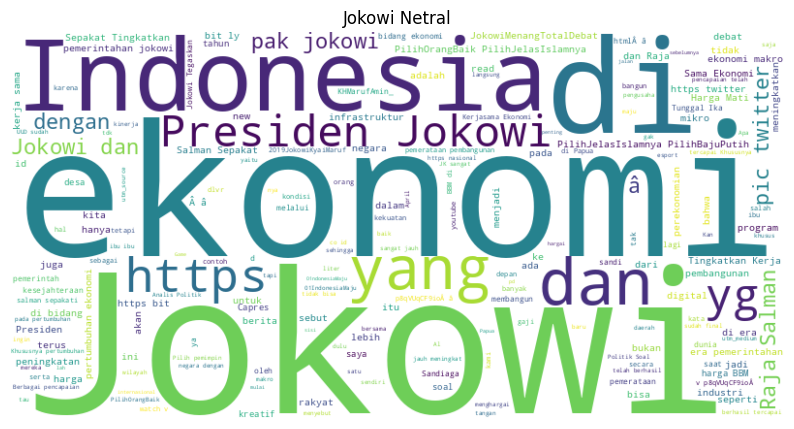

In [ ]:
# jokowi netral
plot_wordcloud(' '.join(joknetlist), title = 'Jokowi Netral')

In [ ]:
# top 3 words for jokowi netral
X = lsa.fit_transform(joknetlist)
get_top_words(X,10,3) #10 n_words and 3 n_clusters

0 : 01, 04, 09 24, 09, 04 14, 10, 09 24 22563621, 1945, 2018, bangunkan
1 : 01indonesiamaju, 01, 01ndonesiamaju, 1a, 1945 sudah final, 1945 sudah, 71, 6500, 2019jokowikyaimaruf https twitter, 22563621 disaksikan
2 : 01, 01ndonesiamaju, 14, aja, 24, akan meningkatkan kerja, 09 24, 2019, 2045, 50ribu liter menjadi


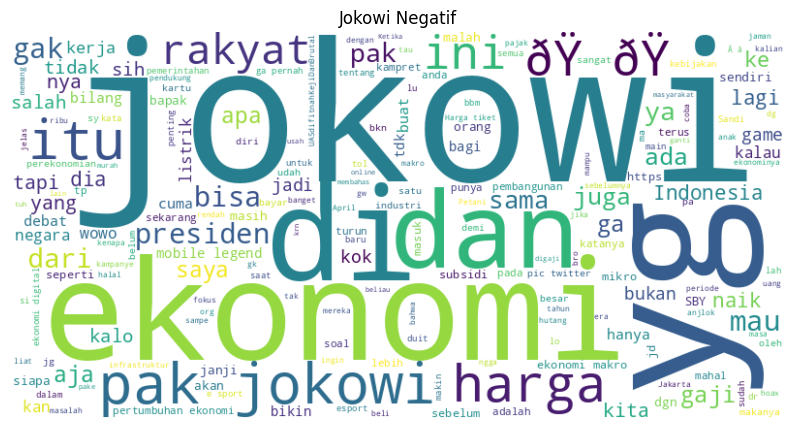

In [ ]:
# jokowi negatif
plot_wordcloud(' '.join(jokneglist), title = 'Jokowi Negatif')

In [ ]:
# top 3 words for Jokowi negatif
X = lsa.fit_transform(jokneglist)
get_top_words(X,10,3) #10 n_words and 3 n_clusters

0 : 17, 6b4ka, 2015, 2014, alasan ekonomi makro, 300, ada jenderal sby, apakah, apa pak jokowi, acara
1 : 17, 50, aja masih, 2x, aja gak, apa ya, agar, ayo, bagus, asing bisa masuk
2 : 17, 17 april, 2014, 50, alasan, bahwa, ada di, acara, apa pak, ada jenderal


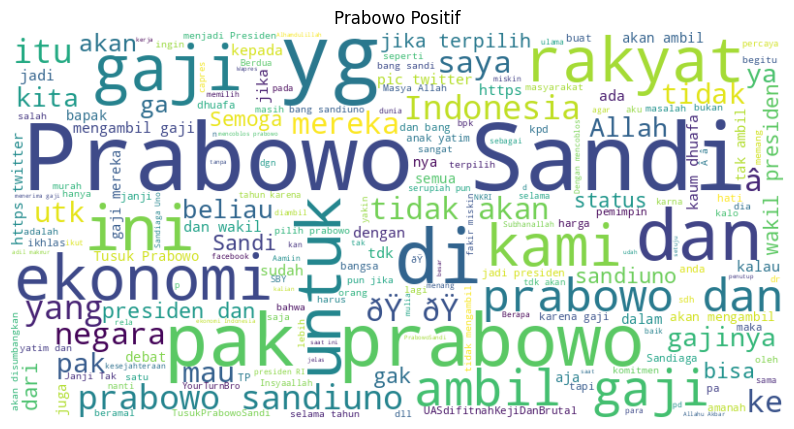

In [ ]:
# prabowo positif
plot_wordcloud(' '.join(praposlist), title = 'Prabowo Positif')

In [ ]:
# top 3 words for Prabowo positif
X = lsa.fit_transform(praposlist)
get_top_words(X,10,3) #10 n_words and 3 n_clusters

0 : 02, 17aprilpilihprabowosandi, akan diambil dan, adalah, akan diberikan, 2019gantipresiden, ayo, ada yg, ambil gaji jika, akbar
1 : 02, 02 prabowo, 17, 17april2019peoplepower, 17 april 2019, akan ambil gaji, amanah ini kami, aja, 2019, akan di
2 : 02, 02 prabowo sandi, 17 april 2019, ada, 2019, 17 april, 17aprilprabowopresidenri, adil dan makmur, akan disedekahkan, adil makmur


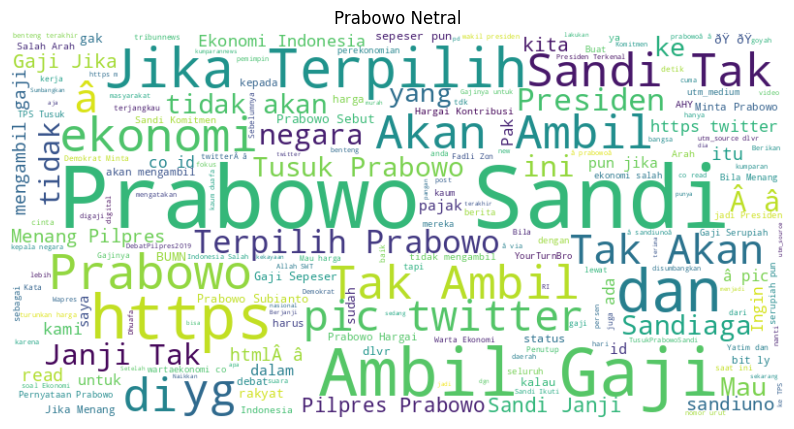

In [ ]:
# prabowo netral
plot_wordcloud(' '.join(pranetlist), title = 'Prabowo Netral')

In [ ]:
# top 3 words for Prabowo netral
X = lsa.fit_transform(pranetlist)
get_top_words(X,10,3) #10 n_words and 3 n_clusters

0 : 02, 04, 04 14 500, 04 14 jika, 04 14 fadli, 1117096753759686657a, 02 prabowo sandi, 04 prabowo sandi, 15, 14 jika
1 : 02, 04 14, 1195559 menang, 1195559 menang pilpres, 13, 14, 14 500, 33, 500, 14 500 985236
2 : 02, 02 prabowo, 02 prabowo sandi, 04 13, 04 prabowo sandi, 2019 prabowo, 20marketing, 985236 keceemokrat, 17, 20marketing utm_medium


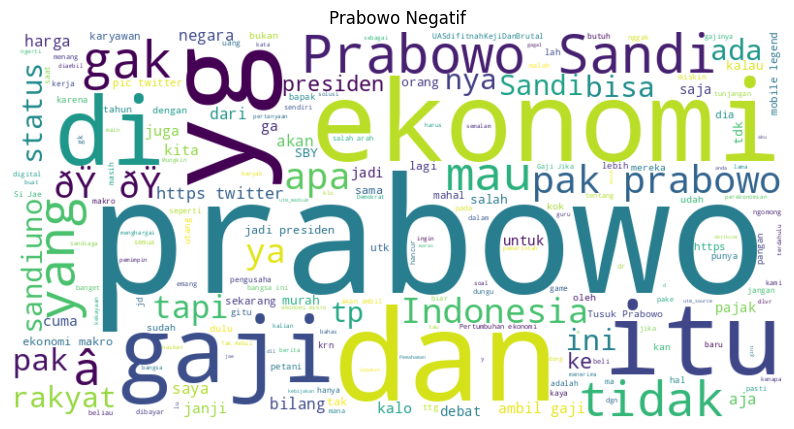

In [ ]:
# prabowo negatif
plot_wordcloud(' '.join(praneglist), title = 'Prabowo Negatif')

In [ ]:
# top 3 words for Prabowo negatif
X = lsa.fit_transform(praneglist)
get_top_words(X,10,3) #10 n_words and 3 n_clusters

0 : 01, 02, 100, 15, adalah, 17 datangi tps, amat, atau, 2019, beli
1 : 01, 17, 33, ada, adegan, adegan iconik di, adegan iconik, akui, anak, bebas
2 : 01, 17 datangi tps, 400, aku, 15, 17 datangi, benci china, apa bapak, bangga, aja ogah


# 3 Data Preparation

In [ ]:
# sampling each class
pos_sample = df[df.sentimen == "positif"][:10]
net_sample = df[df.sentimen == "netral"][:10]
neg_sample = df[df.sentimen == "negatif"][:10]
df_sample = pd.concat([pos_sample, net_sample, neg_sample], axis=0)
# df_sample

Text cleaning will handle:
1. urls
2. hashtags
3. slang words

## 3.1 Cleaning

In [ ]:
from nlp_id.lemmatizer import Lemmatizer
from nlp_id.postag import PosTag
from nlp_id.stopword import StopWord

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### 3.1.1 Create Custom Stopwords

Check stopwords from nlp_id's library:

In [ ]:
# stopwords
stopwords = StopWord().get_stopword()
print(stopwords)

['ada', 'adalagi', 'adalah', 'adanya', 'adapun', 'agak', 'agak-agak', 'agaknya', 'agar', 'aja', 'akan', 'akankah', 'akankan', 'akhir', 'akhir-akhirnya', 'akhirannya', 'akhiri', 'akhirinya', 'akhirnya', 'aku', 'akulah', 'akunya', 'akurat', 'akutu', 'ala', 'alamak', 'alhamdulillah', 'alhasil', 'amat', 'amat-amat', 'amatlah', 'anda', 'anda-anda', 'andai', 'andalah', 'antar', 'antara', 'antaranya', 'apa', 'apa-apanya', 'apaan', 'apabila', 'apaitu', 'apakah', 'apalagi', 'apanya', 'apasaja', 'apatah', 'apesnya', 'arah', 'artinya', 'asal', 'asalkan', 'asumsinya', 'asumsikan', 'atas', 'atas-atas', 'atas-batas', 'ataspun', 'atau', 'ataukah', 'ataupun', 'awal', 'awalnya', 'bagai', 'bagaikan', 'bagaimana', 'bagaimanakah', 'bagaimanapun', 'bagi', 'bagi-bagi', 'bagian', 'bagikan', 'bahasakan', 'bahasanya', 'bahkan', 'bahwa', 'bahwasanya', 'baik', 'bak', 'bakal', 'bakal-bakal', 'bakalan', 'balik', 'balikan', 'balikkan', 'banget', 'banget-banget', 'banyak', 'barangkali', 'baru', 'baru-baru', 'bawah',

**Findings**
- some stopwords may be meaningful for our use case, so we create custom stopwords

In [ ]:
# check nlp_id's stopwords composition
postagger = PosTag()
postag_sw = postagger.get_pos_tag(" ".join(stopwords))

dct = {}
for word, tag in postag_sw:
    if tag not in dct.keys():
        dct[tag] = 1
    else:
        dct[tag] += 1
dct

{'VB': 294,
 'ADV': 286,
 'NN': 231,
 'DT': 59,
 'PR': 163,
 'SC': 66,
 'RP': 86,
 'JJ': 89,
 'IN': 51,
 'CC': 22,
 'NEG': 8,
 'NNP': 2,
 'FW': 4,
 'UH': 2,
 'NUM': 13}

Referring to nlp_id's documentation and considering our use case, the custom stopwords will be the stopwords with tag:
- NEG (negation),
- JJ (adjective),
- VB (verb),
- FW (foreign word),
- NUM (numbers)

In [ ]:
# create custom stopwords
custom_stopwords = [word for word, tag in postag_sw if tag in ['NEG', 'JJ', 'VB', 'FW', 'NUM']]

In [ ]:
len(stopwords), len(custom_stopwords)

(1168, 408)

### 3.1.2 Normalize Indonesian Slang Words  
The slang words dictionary can be found here: https://github.com/nasalsabila/kamus-alay/blob/master/colloquial-indonesian-lexicon.csv

In [ ]:
slang_df = pd.read_csv(data_path + "colloquial-indonesian-lexicon.csv")
slang_dict = slang_df.set_index('slang').to_dict(orient='dict')['formal']

def normalize_slang(text):
    normal_text = []
    text = re.sub(r"[^a-z]", " ", text.lower()) # remove non alphabet
    for word in text.split(" "):
        if word in slang_dict.keys(): word = slang_dict[word] # normalize slang
        if word not in custom_stopwords: normal_text.append(word) # remove stopwords
    return " ".join(normal_text)

### 3.1.3 Run the Cleaning Process  
After trial and errors, we found that normalizing numbers and verbs only produce the best result

In [ ]:
postagger = PosTag()
lemmatizer = Lemmatizer()

def clean(text):
    # remove url and hash tag
    url_pattern = re.compile(r"https?://\S+|www\.\S+|\S+.com/\S+")
    tag_pattern = re.compile(r"#\w+")
    cleaned_text = url_pattern.sub("", text)
    cleaned_text = tag_pattern.sub("", cleaned_text)

    # normalize slang words
    cleaned_text = normalize_slang(cleaned_text)

    phrases_tag = postagger.get_phrase_tag(cleaned_text)
    normal_text_postag = []
    for word, tag in phrases_tag:
        if tag in ['NUM', 'NUMP']:
            word = "NUM" # normalize numbers to "NUM"
        elif tag in ['VB', 'VP']:
            word = lemmatizer.lemmatize(word) # lemmatize only verbs
        normal_text_postag.append(word)
    return " ".join(normal_text_postag)

In [ ]:
df['clean_tweet'] = df.tweet.apply(clean)

In [ ]:
# sampling each class (cross checking the output)
pos_sample = df[df.sentimen == "positif"][:10]
net_sample = df[df.sentimen == "netral"][:10]
neg_sample = df[df.sentimen == "negatif"][:10]
df_sample = pd.concat([pos_sample, net_sample, neg_sample], axis=0)
df_sample

,sentimen,tweet,clean_tweet
3,positif,"Bagi Sumatera Selatan, Asian Games berdampak p...",bagi sumatera selatan asian games dampak pada ...
6,positif,Masa tenang msih ngoceh aja..ttp jokowi harga ...,masa tenang masih oceh saja tetap jokowi harga...
7,positif,#UASdifitnahKejiBalasDiTPS kerjasa ekonomi b...,kerjasa ekonomi bilateral multilateral kita do...
10,positif,#PilihOrangBaik #PilihJelasIslamnya #PilihBaju...,pilih pemimpin itu yang sudah banyak pencapaia...
11,positif,Calon presiden Jokowi menjelaskan program Kart...,calon presiden jokowi program kartu pra kerja ...
13,positif,"Menurut Jokowi, pemerintah selalu berupaya men...",menurut jokowi pemerintah selalu upaya jaga ke...
16,positif,#PilihOrangBaik #PilihJelasIslamnya #PilihBaju...,penting nya sisi industri kreatif dan inovatif...
17,positif,dalam 16 pakta integritas antara Prabowo sandi...,dalam pakta integritas antara prabowo sandi da...
19,positif,Prabowo Sejak jadi TNI puluhan tahun nggak dia...,prabowo sejak tni NUM tahun enggak dia ambil g...
23,positif,Prabowo sandi menang otomatis kita ikut bersed...,prabowo sandi menang otomatis kita sedekah bag...


## 3.2 Split Data

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# split to X-y
X = df['clean_tweet']
y = df['sentimen']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

## 3.3 Label Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
label_enc = LabelEncoder()
y_train_enc = label_enc.fit_transform(y_train)
y_test_enc = label_enc.transform(y_test)

# 4 Embedding and Modeling

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Input, Dense, LSTM, Bidirectional,
                                     Embedding, Dropout)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from kerastuner.tuners import RandomSearch

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import (StratifiedKFold, GridSearchCV,
                                     RandomizedSearchCV)
from sklearn.metrics import accuracy_score, confusion_matrix

tf.random.set_seed(42)
import optuna
from gensim.models import Word2Vec
from nltk import word_tokenize

Functions for Word2Vec:

In [ ]:
# functions
def tokenization(data):
    tokens = []
    for text in data:
        words = word_tokenize(text)
        tokens.append(words)
    return tokens


def get_word2vec_model(tokens, min_count=1, vector_size=100, window=5,
                       method='cbow'):
    assert method in ['cbow', 'skipgram']
    method_dict = {'cbow': 0, 'skipgram': 1}

    embedding_model = Word2Vec(tokens,
                               min_count=min_count,
                               vector_size=vector_size,
                               window=window,
                               sg=method_dict[method], seed=42, workers=1)
    return embedding_model


def get_doc_embedding(tokens, model):
    """ Averaging """
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if not vectors: return
    return sum(vectors) / len(vectors)



## 4.1 Random Forest + TF-IDF

In [ ]:
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(X)

In [ ]:
tfidf_array = tfidf.toarray()
X_tfidf = pd.DataFrame(data=tfidf_array, columns = vectorizer.get_feature_names_out())
X_tfidf.head()

,aa,aaamiin,aalaikum,aamiinn,aaminnnn,aammiin,abadi,abah,abai,abang,...,yusuf,zaenal,zakat,zaman,zer,zero,ziarah,zippo,zon,zonk
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X_tfidf_train, X_tfidf_test, y_train, y_test = train_test_split(X_tfidf, y,
                                                                test_size=0.2,
                                                                stratify=y,
                                                                random_state=42)

In [ ]:
rf = RandomForestClassifier()

param = {
    'n_estimators': [i for i in range(10, 110, 10)],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None] + [i for i in range(1, 11)],
    'min_samples_split': [i for i in range(2, 11)],
    'min_samples_leaf': [i for i in range(1, 11)],
    'max_features': ['sqrt', 'log2', None],
    'max_leaf_nodes': [None] + [i for i in range(1, 11)],
}

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param,
    n_iter=300,
    cv=5,
    random_state=28,
    n_jobs=-1
)

In [ ]:
random_search.fit(X_tfidf_train, y_train)

best_rf_model = random_search.best_estimator_

The parameters obtained from random search are used to train the model:

In [ ]:
best_params = {'n_estimators': 90,
               'min_samples_split': 10,
               'min_samples_leaf': 5,
               'max_leaf_nodes': None,
               'max_features': 'sqrt',
               'max_depth': None,
               'criterion': 'entropy'}

best_rf_model = RandomForestClassifier(**best_params)

In [ ]:
best_rf_model.fit(X_tfidf_train, y_train)
y_pred_test = best_rf_model.predict(X_tfidf_test)

accuracy_test = accuracy_score(y_test, y_pred_test)

print("Best Accuracy:", accuracy_test)

Best Accuracy: 0.6143250688705234


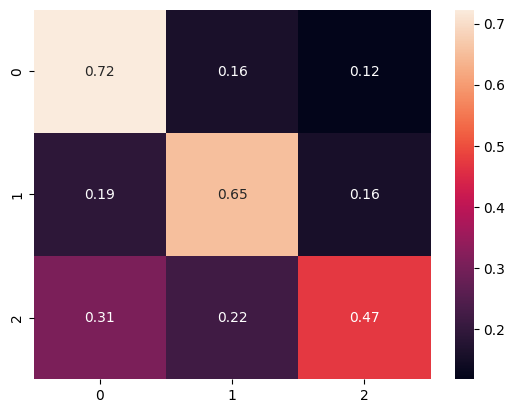

In [ ]:
cm = confusion_matrix(y_test, y_pred_test)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cmn, annot=True, fmt='.2f',)
plt.show()

Findings
- RF + TF IDF produces 61.4% validation accuracy
- the model misclassifies positive class the most

## 4.2 Random Forest + Word2Vec

In [ ]:
all_tokens = tokenization(X)
train_tokens = tokenization(X_train)
test_tokens = tokenization(X_test)

result = {'min_count': [], 'window': [], 'accuracy': []}

for min_count in [1, 2, 3, 4, 5]:
    for window in [2, 3, 5, 7, 8, 10]:
        sg_model = get_word2vec_model(all_tokens,
                                      min_count=min_count,
                                      window=window,
                                      method='skipgram')
        sg_model.train(all_tokens,
                    total_examples=sg_model.corpus_count,
                    epochs=sg_model.epochs)

        # get the embedded data with skipgram model
        train_data = [get_doc_embedding(tokens, sg_model) for tokens in train_tokens]
        test_data = [get_doc_embedding(tokens, sg_model) for tokens in test_tokens]

        # base RF model
        clf = RandomForestClassifier(random_state=42)
        # fit and predict
        clf.fit(train_data, y_train_enc)
        predictions = clf.predict(test_data)
        # accuracy
        accuracy = accuracy_score(y_test_enc, predictions)

        result['min_count'].append(min_count)
        result['window'].append(window)
        result['accuracy'].append(accuracy)
pd.DataFrame(result)

In [ ]:
# vector size
train_tokens = tokenization(X_train)
test_tokens = tokenization(X_test)

result = {'min_count': [], 'window': [], 'vector_size': [],'accuracy': []}
min_count = 4
window = 7

for vector_size in [25, 50, 100, 150, 300]:
    sg_model = get_word2vec_model(all_tokens,
                                    min_count=min_count,
                                    window=window,
                                  vector_size=vector_size,
                                    method='skipgram')
    sg_model.train(all_tokens,
                total_examples=sg_model.corpus_count,
                epochs=sg_model.epochs)

    # get the embedded data with skipgram model
    train_data = [get_doc_embedding(tokens, sg_model) for tokens in train_tokens]
    test_data = [get_doc_embedding(tokens, sg_model) for tokens in test_tokens]

    # base RF model
    clf = RandomForestClassifier(random_state=42)
    # fit and predict
    clf.fit(train_data, y_train_enc)
    predictions = clf.predict(test_data)
    # accuracy
    accuracy = accuracy_score(y_test_enc, predictions)

    result['min_count'].append(min_count)
    result['window'].append(window)
    result['vector_size'].append(vector_size)
    result['accuracy'].append(accuracy)
pd.DataFrame(result)

After trial and error fitting random forest using various min_count, window and vector_size value for word2vec, create the train test data using the best value for word2vec is as following:

In [ ]:
# skipgram is better than cbow for this case
skipgram = get_word2vec_model(train_tokens,
                              min_count=4,
                              window=7,
                              vector_size=100,
                              method='skipgram')

skipgram.train(train_tokens,
               total_examples=skipgram.corpus_count,
               epochs=skipgram.epochs)

train_data = [get_doc_embedding(tokens, skipgram) for tokens in train_tokens]
test_data = [get_doc_embedding(tokens, skipgram) for tokens in test_tokens]

Hyperparameter tune the random forest:

In [ ]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 5, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'random_state': 42
    }

    clf = RandomForestClassifier(**params)
    clf.fit(train_data, y_train_enc)
    predictions = clf.predict(test_data)
    accuracy = accuracy_score(y_test_enc, predictions)
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params
best_params['random_state'] = 42

Fit using the best hyperparameters:

In [ ]:
best_params = {'n_estimators': 35,
               'min_samples_split': 3,
               'min_samples_leaf': 4,
               'max_features': None}

In [ ]:
clf = RandomForestClassifier(**best_params)
clf.fit(train_data, y_train_enc)

# predict train data
predictions = clf.predict(train_data)
print(accuracy_score(y_train_enc, predictions))

# predict test data
predictions = clf.predict(test_data)
print(accuracy_score(y_test_enc, predictions))

0.953168044077135
0.6143250688705234


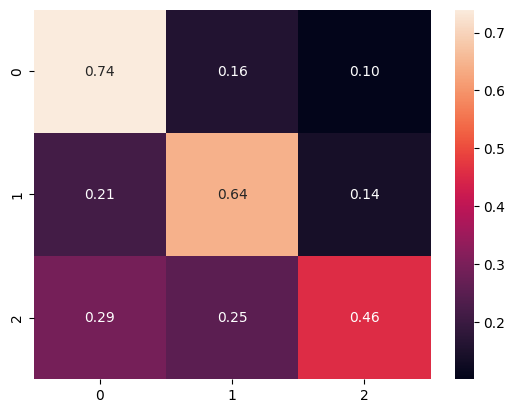

In [ ]:
cm = confusion_matrix(y_test, y_pred_test)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cmn, annot=True, fmt='.2f',)
plt.show()

**Findings**
- RF + word2vec gives 61.4% validation accuracy
- the model missclassifies positive class the most

## 4.3 LSTM + TF-IDF  
Running this scenario using RandomSearch from keras_tuner

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import RandomSearch

In [ ]:
max_words = 5000
maxlen = tfidf_array.shape[1]

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(Bidirectional(LSTM(hp.Int('lstm_units', 32, 64, step=16), input_shape=(maxlen,))))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=2,
    directory='hasil_lstm_tfidf',
    project_name='sentiment_analysis'
)

In [ ]:
tuner.search(X_tfidf_train, np.array(y_train_enc),
             epochs=100,
             validation_split=0.2,
             callbacks=[early_stopping])

Findings
- The tuner search will show the best val accuracy value, which is 57.38%
- The result is not better than using random forest, therefore we wont evaluate the confusion matrix

## 4.4 LSTM + Embedding Layer

In [ ]:
# cross check vocab size based on X data
vocab_temp = set()
for t in X:
    vocab_temp = vocab_temp.union(set(t.split(' ')))
len(vocab_temp)

5169

In [ ]:
model = create_model(
    dynamic_embedding=True,
    vector_size=(100,),
    vocab_size=10000,
    embedding_dim=32,
    max_len=train_data.shape[1],
    lstm_unit=[16, 8],
    learning_rate=1e-3,
    bidirectional=False)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 56)]              0         
                                                                 
 embedding (Embedding)       (None, 56, 32)            320000    
                                                                 
 lstm (LSTM)                 (None, 56, 16)            3136      
                                                                 
 lstm_1 (LSTM)               (None, 8)                 800       
                                                                 
 dense (Dense)               (None, 3)                 27        
                                                                 
Total params: 323963 (1.24 MB)
Trainable params: 323963 (1.24 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
train_hist = model.fit(train_data, y_train_enc,
                       validation_data=(test_data, y_test_enc),
                       epochs=100)

In [ ]:
print(max(train_hist.history['val_accuracy']))

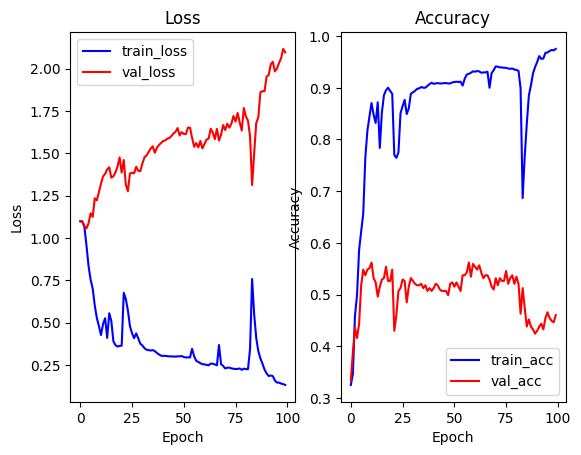

In [ ]:
plot_lc(train_hist)

## 4.5 LSTM + Word2Vec

In [ ]:
model = create_model(
    dynamic_embedding=False,
    vector_size=(100,1),
    vocab_size=10000,
    embedding_dim=32,
    max_len=100,
    lstm_unit=[16, 8],
    learning_rate=1e-3,
    bidirectional=False,
    dropout=True)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 1)]          0         
                                                                 
 lstm (LSTM)                 (None, 100, 16)           1152      
                                                                 
 dropout (Dropout)           (None, 100, 16)           0         
                                                                 
 lstm_1 (LSTM)               (None, 8)                 800       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 3)                 27        
                                                                 
Total params: 1979 (7.73 KB)
Trainable params: 1979 (7.73 KB)

In [ ]:
train_hist = model.fit(train_data, y_train_enc,
                            validation_data=(test_data, y_test_enc),
                            epochs=200)

In [ ]:
print(max(train_hist.history['val_accuracy']))

0.589531660079956


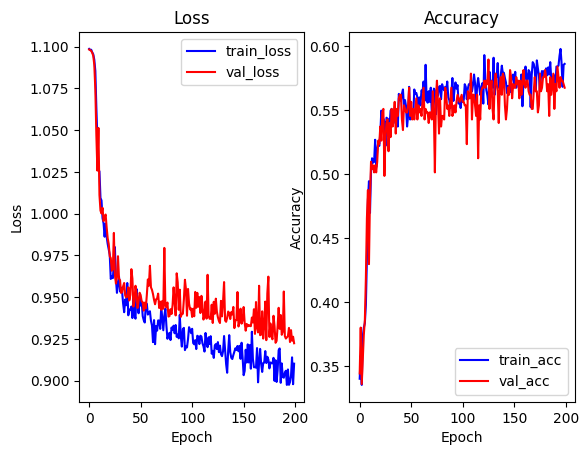

In [ ]:
plot_lc(train_hist)

## 4.6 BERT

In [ ]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification

pretrained= "mdhugol/indonesia-bert-sentiment-classification"

model = AutoModelForSequenceClassification.from_pretrained(pretrained)
tokenizer = AutoTokenizer.from_pretrained(pretrained)

sentiment_analysis = pipeline("sentiment-analysis",
                              model=model,
                              tokenizer=tokenizer)

# pre defined label index
label_index = {'LABEL_0': 'positif', 'LABEL_1': 'netral', 'LABEL_2': 'negatif'}


config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
# predict
train_results = sentiment_analysis(X_train.tolist())
test_results = sentiment_analysis(X_test.tolist())

In [ ]:
y_pred_train = [label_index[x['label']] for x in train_results]
y_pred_test = [label_index[x['label']] for x in test_results]

In [ ]:
# evaluate
train_acc = accuracy_score(y_train.values, y_pred_train)
test_acc = accuracy_score(y_test.values, y_pred_test)
print(train_acc, test_acc)

0.6253443526170799 0.6363636363636364


**Findings**  
The BERT model produces the best validation accuracy.  
The confusion matrix:

In [ ]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
cm

array([[94, 13, 12],
       [26, 73, 22],
       [42, 17, 64]])

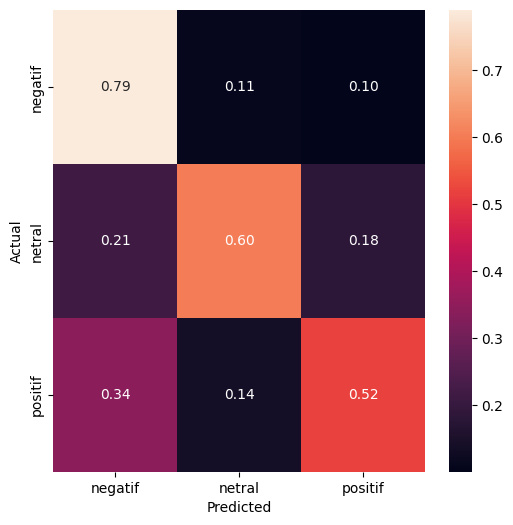

In [ ]:
# visualization
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(cmn, annot=True, fmt='.2f',
            xticklabels=['negatif', 'netral', 'positif'],
            yticklabels=['negatif', 'netral', 'positif']
            )
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [ ]:
y_test.value_counts()

positif    123
netral     121
negatif    119
Name: sentimen, dtype: int64

# 5 Summary

1. After trying various scenarios, the best result is using random forest model with word2vec embedding
2. All scenarios suffer from overfitting
3. In general, using Random Forest for this use case is better

4. As benchmark, the pretrained BERT model produces 63.63% validation accuracy, which means, our Random Forest + Word2vec model performs quite similar